# Predicting prices with a single-asset regression model

## Preparing the independent and target variables

In [3]:
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_jpm, meta_data = ts.get_daily_adjusted(
    symbol='JPM', outputsize='full')
df_gs, meta_data = ts.get_daily_adjusted(
    symbol='GS', outputsize='full')

In [4]:
import pandas as pd

df_x = pd.DataFrame({'GS': df_gs['5. adjusted close']})

In [5]:
jpm_prices = df_jpm['5. adjusted close']

## Writing the linear regression model

In [6]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        df.sort_index(inplace=True)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]

In [7]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                       end_date='2019', lookback_period=20)

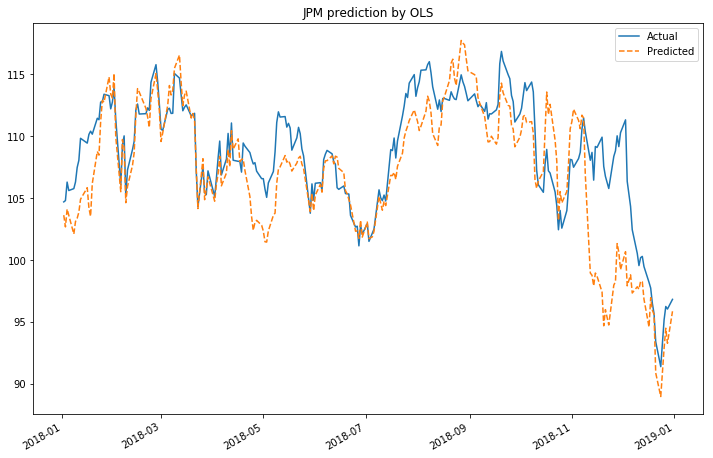

In [8]:
%matplotlib inline

linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

## Risk metrics for measuring prediction performance

### Mean absolute error (MAE) as a risk metric

In [12]:
from sklearn.metrics import mean_absolute_error

actual = linear_reg_model.df_result['Actual']
predicted = linear_reg_model.df_result['Predicted']

mae = mean_absolute_error(actual, predicted)
print('mean absolute error:', mae)

mean absolute error: 2.4581681193682257


#### Mean squared error (MSE) as a risk metric

In [15]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predicted)
print('mean squared error:', mse)

mean squared error: 12.156831789513527


### Explained variance score as a risk metric

In [16]:
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

explained variance score: 0.533223710321685


### R<sup>2</sup> as a risk metric

In [17]:
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted) 
print('r2 score:', r2)

r2 score: 0.41668262740620565


## Ridge regression

In [19]:
from sklearn.linear_model import Ridge

class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

In [20]:
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

In [21]:
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, 
    explained_variance_score, r2_score
)
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))    

In [23]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 1.5894857982072854
mean_squared_error: 4.519781391552921
explained_variance_score: 0.7954234004448739
r2_score: 0.7831287746949672


# Predicting returns with a cross-asset momentum model

## Preparing the independent variables

In [24]:
df_spx, meta_data = ts.get_daily_adjusted(
    symbol='SPX', outputsize='full')
df_gld, meta_data = ts.get_daily_adjusted(
    symbol='GLD', outputsize='full')
df_dxy, dxy_meta_data = ts.get_daily_adjusted(
    symbol='UUP', outputsize='full')
df_ief, meta_data = ts.get_daily_adjusted(
    symbol='IEF', outputsize='full')

In [25]:
import pandas as pd

df_assets = pd.DataFrame({
    'SPX': df_spx['5. adjusted close'],
    'GLD': df_gld['5. adjusted close'],
    'UUP': df_dxy['5. adjusted close'],
    'IEF': df_ief['5. adjusted close'],
}).dropna()

In [26]:
df_assets_1m = df_assets.pct_change(periods=20)
df_assets_1m.columns = ['%s_1m'%col for col in df_assets.columns]

df_assets_3m = df_assets.pct_change(periods=60)
df_assets_3m.columns = ['%s_3m'%col for col in df_assets.columns]

df_assets_6m = df_assets.pct_change(periods=120)
df_assets_6m.columns = ['%s_6m'%col for col in df_assets.columns]

df_assets_12m = df_assets.pct_change(periods=240)
df_assets_12m.columns = ['%s_12m'%col for col in df_assets.columns]

In [27]:
df_lagged = df_assets_1m.join(df_assets_3m)\
    .join(df_assets_6m)\
    .join(df_assets_12m)\
    .dropna()

In [28]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2792 entries, 2008-02-12 to 2019-03-15
Data columns (total 16 columns):
SPX_1m     2792 non-null float64
GLD_1m     2792 non-null float64
UUP_1m     2792 non-null float64
IEF_1m     2792 non-null float64
SPX_3m     2792 non-null float64
GLD_3m     2792 non-null float64
UUP_3m     2792 non-null float64
IEF_3m     2792 non-null float64
SPX_6m     2792 non-null float64
GLD_6m     2792 non-null float64
UUP_6m     2792 non-null float64
IEF_6m     2792 non-null float64
SPX_12m    2792 non-null float64
GLD_12m    2792 non-null float64
UUP_12m    2792 non-null float64
IEF_12m    2792 non-null float64
dtypes: float64(16)
memory usage: 359.9+ KB


## Preparing the target variables

In [29]:
y = jpm_prices.pct_change().dropna()

In [30]:
multi_linear_model = LinearRegressionModel()
multi_linear_model.learn(df_lagged, y, start_date='2018', 
                         end_date='2019', lookback_period=10)

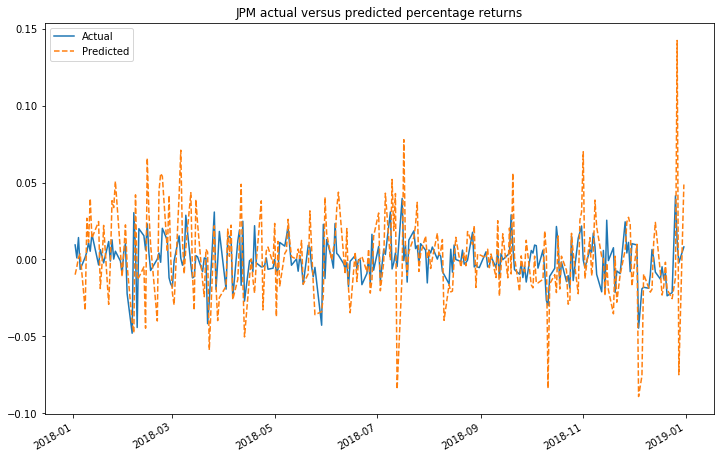

In [32]:
multi_linear_model.df_result.plot(
    title='JPM actual versus predicted percentage returns',
    style=['-', '--'], figsize=(12,8));

In [33]:
print_regression_metrics(multi_linear_model.df_result)

mean_absolute_error: 0.019523019808983168
mean_squared_error: 0.000722550861810258
explained_variance_score: -2.7298040463350692
r2_score: -2.738407558560419


## An ensemble of decision trees

### Bagging regressor

In [34]:
from sklearn.ensemble import BaggingRegressor

class BaggingRegressorModel(LinearRegressionModel):
    def get_model(self):
        return BaggingRegressor(n_estimators=20, random_state=0)  

In [35]:
bagging = BaggingRegressorModel()
bagging.learn(df_lagged, y, start_date='2018', 
              end_date='2019', lookback_period=10)

In [36]:
print_regression_metrics(bagging.df_result)

mean_absolute_error: 0.011469926472278664
mean_squared_error: 0.0002463521857419121
explained_variance_score: -0.2722603048485479
r2_score: -0.2746021379561929


# Predicting trends with classification-based machine learning

## Preparing the target variables

In [37]:
import numpy as np
y_direction = y >= 0

In [38]:
y_direction.head(3)

date
1998-01-05     True
1998-01-06    False
1998-01-07     True
Name: 5. adjusted close, dtype: bool

In [39]:
flags = list(y_direction.unique())
flags.sort()

In [40]:
print(flags)

[False, True]


## Preparing the dataset of multiple assets as input variables

In [41]:
df_input = df_assets_1m.join(df_assets_3m).dropna()

In [42]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2972 entries, 2007-05-25 to 2019-03-15
Data columns (total 8 columns):
SPX_1m    2972 non-null float64
GLD_1m    2972 non-null float64
UUP_1m    2972 non-null float64
IEF_1m    2972 non-null float64
SPX_3m    2972 non-null float64
GLD_3m    2972 non-null float64
UUP_3m    2972 non-null float64
IEF_3m    2972 non-null float64
dtypes: float64(8)
memory usage: 197.4+ KB


## Logistic regression

In [43]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression(solver='lbfgs')

In [44]:
logistic_reg_model = LogisticRegressionModel()
logistic_reg_model.learn(df_input, y_direction, start_date='2018', 
                         end_date='2019', lookback_period=100)

In [45]:
logistic_reg_model.df_result.head()

,Actual,Predicted
2018-01-02,True,True
2018-01-03,True,True
2018-01-04,True,True
2018-01-05,False,True
2018-01-08,True,True


### Risk metrics for measuring classification-based predictions

### Confusion matrix

In [47]:
from sklearn.metrics import confusion_matrix

df_result = logistic_reg_model.df_result    
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

matrix = confusion_matrix(actual, predicted)

In [48]:
print(matrix)

[[60 66]
 [55 70]]


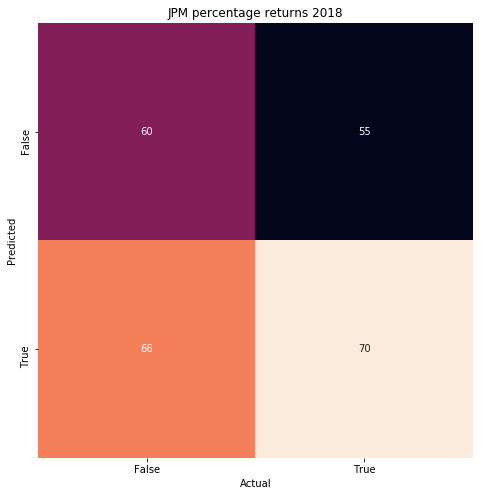

In [49]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,8))
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=flags, yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('JPM percentage returns 2018');

### Accuracy score

In [50]:
from sklearn.metrics import accuracy_score
print('accuracy_score:', accuracy_score(actual, predicted))

accuracy_score: 0.5179282868525896


### Precision score

In [51]:
from sklearn.metrics import precision_score
print('precision_score:', precision_score(actual, predicted))

precision_score: 0.5147058823529411


### Recall score

In [52]:
from sklearn.metrics import recall_score
print('recall_score:', recall_score(actual, predicted))

recall_score: 0.56


### F1 Score

In [53]:
from sklearn.metrics import f1_score
print('f1_score:', f1_score(actual, predicted))

f1_score: 0.5363984674329502


## Support Vector Classifier

In [57]:
from sklearn.svm import SVC

class SVCModel(LogisticRegressionModel):
    def get_model(self):
        return SVC(C=1000, gamma='auto')

In [58]:
svc_model = SVCModel()
svc_model.learn(df_input, y_direction, start_date='2018', 
                end_date='2019', lookback_period=100)

In [59]:
df_result = svc_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

print('accuracy_score:', accuracy_score(actual, predicted))
print('precision_score:', precision_score(actual, predicted))
print('recall_score:', recall_score(actual, predicted))
print('f1_score:', f1_score(actual, predicted))    

accuracy_score: 0.5577689243027888
precision_score: 0.5538461538461539
recall_score: 0.576
f1_score: 0.5647058823529412
